This code is used to provide some insights on the distribution of land use for each district (over time). Change the year in the landuse string between 2017-2021 to derive the distribution for different years. Do not forget to set the year in csv equal to the one selected in 'landuse'.
Besides, this code also provides a choropleth map for the average soil moisture for each district.

In [59]:
import shapely
import os 
os.chdir('C:/Users/Lenovo/Desktop/Master_BAOR/MSc Thesis')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyproj
import pprint
import folium
from IPython.display import display
import rasterio
from rasterio.plot import show_hist
from rasterio.plot import show
from rasterio import features
import rasterstats
from shapely.geometry import shape
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon

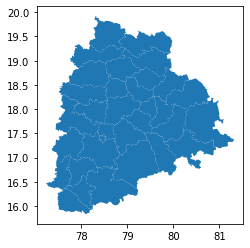

In [60]:
# Read the districts file
soil_districts = gpd.read_file('C:/Users/Lenovo/Desktop/Master_BAOR/MSc Thesis/dowloaded from DiCRA/SOILM/SOILM_2022/VECTOR/DISTRICT/23-01-2022.geojson')
soil_districts.plot()
# Read the landuse raster
landuse = "C:/Users/Lenovo/Desktop/Master_BAOR/MSc Thesis/dowloaded from DiCRA/LULC/01-01-2021.tif"
lulc = rasterio.open(landuse, mode = 'r')
#show(lulc)

In [61]:
# Plotting the raster and the districts file together
#fig, ax = plt.subplots(1,1) # we just have 1 subplot (you can also change figsize = (10,10))
#show(lulc, ax = ax, title = 'Land cover')
#soil_districts.plot(ax = ax, facecolor = 'None', edgecolor = 'black')
#plt.show()
# show_hist: showing the histogram of a particular raster that we are going to assign for it
#show_hist(lulc, title = 'Histogram')

In [62]:
# Assign raster values to a numpy nd array
lulc_array = lulc.read(1) # landuse corresponding to each rasterpixel, so we extracted the pixel values from the raster
# affine: 1: corresponds to the width of each pixel, 2: row rotation, 3: x-coordinate of the upper left pixel, 4: column rotation, 5: height of each pixel, 6: y-coordinate of the upper left pixel
affine = lulc.transform
lulc.meta
# Geographical coordinate reference system is used (4326)
# lulc.nodata # value which has been assigned for the nodata

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 44858,
 'height': 44871,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(9.093734367792083e-05, 0.0, 77.23727764548599,
        0.0, -9.093734367792064e-05, 19.916876996752308)}

In [63]:
# Calculating the zonal statistics 1
# Since we use categorical variables, the output is a dictionary with the unique raster values as keys and pixel counts as values
cmap = {1: 'Water', 2: 'Trees', 4: 'Flooded Vegetation', 5: 'Crops', 7: 'Built Area', 8: 'Bare Ground', 9: 'Snow/Ice', 10: 'Clouds', 11: 'Rangeland'}
count_lulc = rasterstats.zonal_stats(soil_districts, lulc_array, affine = affine, geojson_out = True, nodata = lulc.nodata, categorical=True, category_map = cmap)
# Extracting the landuse counts from the list
counts_lulc = []
i = 0
while i < len(count_lulc):
    counts_lulc.append(count_lulc[i]['properties'])
    i = i + 1

In [64]:
# Calculating the zonal statistics 2
# NOTE: stats must be any of these ['count', 'min', 'max', 'mean', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range', 'nodata', 'nan']
mode_lulc = rasterstats.zonal_stats(soil_districts, lulc_array, affine = affine, stats = ['majority'], geojson_out = True, nodata = lulc.nodata)
# Extracting the landuse statistics from the list
modes_lulc = []
i = 0
while i < len(mode_lulc):
    modes_lulc.append(mode_lulc[i]['properties'])
    i = i + 1

In [65]:
# Extracting the soil statistics from the list
soil_stats = []
i = 0
while i < len(soil_districts):
    soil_stats.append(soil_districts['zonalstat'][i]['mean'])
    i = i + 1
soil_df = pd.DataFrame(soil_stats, columns = ['Mean'])

In [66]:
# Transfering the information from the lists to a pandas dataframe
counts_lulc_df = pd.DataFrame(counts_lulc)
statistics_df = pd.DataFrame(modes_lulc)
# Calculate for each district the percentage of land used for Crop
counts_lulc_df['Sum'] = counts_lulc_df.iloc[:,4:].sum(axis=1)
counts_lulc_df['Percentage Crop'] = counts_lulc_df['Crops'] / counts_lulc_df['Sum'] * 100
# Determine for each district which class is the majority
counts_lulc_df['Majority'] = statistics_df['majority']
# Determine for each district the average soil moisture
counts_lulc_df['Average Soil Moisture'] = soil_df['Mean']


In [67]:
# Save the dataframe in excel 
counts_lulc_df.to_csv('landuse_analysis_2021.csv')

Text(81.67146265930535, 0.5, 'latitude')

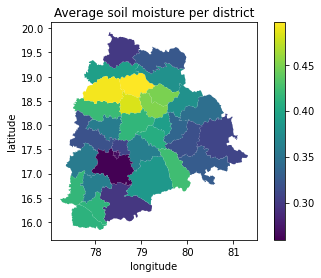

In [68]:
soil_districts['Mean'] = soil_df['Mean']
soil_districts.plot(column = 'Mean', legend = True)
plt.title('Average soil moisture per district')
plt.xlabel('longitude')
plt.ylabel('latitude')